# Test whether including old data improves performance

We have data from 1963-1997, but only at hourly frequency (whereas the competition data is a 1-minute frequency). This notebook tests whether an hourly model using all the data is better than a high-frequency model trained only on the recent data.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import datetime as dt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from model_definitions import (define_model_cnn_1_min, define_model_cnn_hourly, define_model_transformer_1_min, define_model_transformer_hourly)
from preprocessing import combine_old_and_new_data, prepare_data_1_min
from predict import load_models, predict_batch
from train import train_nn_models, train_on_prepared_data
import time
from typing import Callable, Tuple
import tensorflow as tf
from plotting import plot_binned_RMSE
import matplotlib.pyplot as plt


In [2]:
# download and save data
# !wget https://ngdc.noaa.gov/geomag/data/geomag/magnet/public.zip
# !unzip public.zip
# !wget https://ngdc.noaa.gov/geomag/data/geomag/magnet/private.zip
# !unzip private.zip
# !mkdir data
# !mv public data
# !mv private data

In [2]:
# user options
retrain_models = True # if true, train and save models, otherwise load pre-trained models from disk
model_name_1_min = "transformer_1_min"
model_def_1_min = define_model_transformer_1_min
model_name_hourly = "transformer_hourly"
model_def_hourly = define_model_transformer_hourly

In [3]:
# load recent data
data_folder = "data"
solar_train = pd.read_csv(os.path.join(data_folder, "public", "solar_wind.csv"))
dst_train = pd.read_csv(os.path.join(data_folder, "public", "dst_labels.csv"))
sunspots_train = pd.read_csv(os.path.join(data_folder, "public", "sunspots.csv"))
solar_test = pd.read_csv(os.path.join(data_folder, "private", "solar_wind.csv"))
dst_test = pd.read_csv(os.path.join(data_folder, "private", "dst_labels.csv"))
sunspots_test = pd.read_csv(os.path.join(data_folder, "private", "sunspots.csv"))

In [5]:
# train 1-minute model
# output_folder = os.path.join("trained_models", model_name_1_min, "benchmark")
# os.makedirs(output_folder, exist_ok=True)
# if retrain_models:
#     train_nn_models(solar_train, sunspots_train, dst_train, model_def_1_min, 1, output_folder, "minute", early_stopping=True)

In [4]:
output_folder = os.path.join("trained_models", model_name_1_min, "benchmark")
solar_1_min, train_cols = prepare_data_1_min(
    solar_train.copy(), sunspots_train.copy(), dst_train, output_folder=output_folder, norm_df=None
)


In [8]:
model_def_1_min = define_model_transformer_1_min
model, initial_weights, epochs, lr, bs = model_def_1_min()
train_on_prepared_data(
        solar_1_min,
        model,
        initial_weights,
        epochs,
        lr,
        bs,
        train_cols,
        1,
        output_folder,
        "minute",
        True,
        False
    )

Epoch 1/100
3469/3469 [==============================] - 122s 34ms/step - loss: 251.1143 - root_mean_squared_error: 15.7705 - val_loss: 105.7885 - val_root_mean_squared_error: 10.2854
Epoch 2/100
3469/3469 [==============================] - 122s 35ms/step - loss: 113.1794 - root_mean_squared_error: 10.6370 - val_loss: 91.5268 - val_root_mean_squared_error: 9.5670
Epoch 3/100
3469/3469 [==============================] - 121s 35ms/step - loss: 95.3559 - root_mean_squared_error: 9.7638 - val_loss: 80.6699 - val_root_mean_squared_error: 8.9816
Epoch 4/100
3469/3469 [==============================] - 121s 35ms/step - loss: 82.3131 - root_mean_squared_error: 9.0724 - val_loss: 86.2364 - val_root_mean_squared_error: 9.2864
Epoch 5/100
3469/3469 [==============================] - 121s 35ms/step - loss: 77.0140 - root_mean_squared_error: 8.7755 - val_loss: 86.1939 - val_root_mean_squared_error: 9.2841
Epoch 6/100
3469/3469 [==============================] - 121s 35ms/step - loss: 71.2984 - root

In [9]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1008, 13)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 335, 64)      5056        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 110, 64)      24640       conv1d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 110, 64)      0           conv1d_1[0][0]                   
______________________________________________________________________________________________

In [5]:
# Load older data
solar_old = pd.read_csv(os.path.join(data_folder, "old", "solar_wind.csv"))
dst_old = pd.read_csv(os.path.join(data_folder, "old", "dst_labels.csv"))
sunspots_old = pd.read_csv(os.path.join(data_folder, "old", "sunspots.csv"))
# Merge data - train on old and recent public data, test on recent private data
solar_train_hourly = combine_old_and_new_data(solar_old, solar_train)
sunspots_train_hourly = pd.concat([sunspots_train, sunspots_old], axis=0)
dst_train_hourly = pd.concat([dst_train, dst_old], axis=0)
solar_test_hourly = solar_test.copy()
# Extract hourly data
solar_test_hourly = combine_old_and_new_data(pd.DataFrame(), solar_test)

In [ ]:
# train hourly model
output_folder = os.path.join("trained_models", model_name_hourly, "benchmark")
os.makedirs(output_folder, exist_ok=True)
if retrain_models:
    train_nn_models(solar_train_hourly, sunspots_train_hourly, dst_train_hourly, model_def_hourly, 1, output_folder, "hour", early_stopping=True)

Epoch 1/100
10936/10936 [==============================] - 638s 58ms/step - loss: 341.1693 - root_mean_squared_error: 18.4171 - val_loss: 253.2236 - val_root_mean_squared_error: 15.9130
Epoch 2/100
 6588/10936 [=================>............] - ETA: 3:53 - loss: 227.1563 - root_mean_squared_error: 15.0708

In [6]:
# measure performance - 1 minute model
output_folder = os.path.join("trained_models", model_name_1_min, "benchmark")
model_t_arr, model_t_plus_1_arr, norm_df = load_models(output_folder, 1)
dst_test["timedelta"] = pd.to_timedelta(dst_test["timedelta"])
# exclude times in the first week + 1 hour of dst_test
dst_test = dst_test.loc[dst_test["timedelta"] >= dt.timedelta(days=7, hours=1)].copy()
predictions = predict_batch(
    solar_test.copy(), sunspots_test, dst_test, model_t_arr, model_t_plus_1_arr, norm_df, "minute", False
)
dst_test_1_min = pd.merge(dst_test, predictions, "left", ["timedelta", "period"])
dst_test_1_min["dst_t_plus_1"] = dst_test_1_min.groupby("period")["dst"].shift(-1)
loss_t = np.sqrt(
    mean_squared_error(dst_test_1_min["dst"].values, dst_test_1_min["prediction_t"].values)
)
valid_ind = dst_test_1_min["dst_t_plus_1"].notnull()
loss_t_plus_1 = np.sqrt(
    mean_squared_error(
        dst_test_1_min.loc[valid_ind, "dst_t_plus_1"].values,
        dst_test_1_min.loc[valid_ind, "prediction_t_plus_1"].values,
    )
)

print(f"RMSE for time t: {loss_t:0.2f}")
print(f"RMSE for time t+1: {loss_t_plus_1:0.2f}")

RMSE for time t: 13.20
RMSE for time t+1: 13.81


In [7]:
# measure performance - hourly model
output_folder = os.path.join("trained_models", model_name_hourly, "benchmark")
model_t_arr, model_t_plus_1_arr, norm_df = load_models(output_folder, 1)
dst_test["timedelta"] = pd.to_timedelta(dst_test["timedelta"])
# exclude times in the first week + 1 hour of dst_test
dst_test = dst_test.loc[dst_test["timedelta"] >= dt.timedelta(days=7, hours=1)].copy()
predictions = predict_batch(
    solar_test_hourly.copy(), sunspots_test, dst_test, model_t_arr, model_t_plus_1_arr, norm_df, "hour"
)
dst_test_hourly = pd.merge(dst_test, predictions, "left", ["timedelta", "period"])
dst_test_hourly["dst_t_plus_1"] = dst_test_hourly.groupby("period")["dst"].shift(-1)
loss_t = np.sqrt(
    mean_squared_error(dst_test_hourly["dst"].values, dst_test_hourly["prediction_t"].values)
)
valid_ind = dst_test_hourly["dst_t_plus_1"].notnull()
loss_t_plus_1 = np.sqrt(
    mean_squared_error(
        dst_test_hourly.loc[valid_ind, "dst_t_plus_1"].values,
        dst_test_hourly.loc[valid_ind, "prediction_t_plus_1"].values,
    )
)

print(f"RMSE for time t: {loss_t:0.2f}")
print(f"RMSE for time t+1: {loss_t_plus_1:0.2f}")

RMSE for time t: 14.88
RMSE for time t+1: 14.26


In [8]:
# blend the two models
dst_test_blend = dst_test_hourly.copy()
hourly_weight = 0.5
dst_test_blend["prediction_t"] = dst_test_hourly["prediction_t"] * hourly_weight + dst_test_1_min["prediction_t"] * (1 - hourly_weight)
dst_test_blend["prediction_t_plus_1"] = dst_test_hourly["prediction_t_plus_1"] * hourly_weight + dst_test_1_min["prediction_t_plus_1"] * (1 - hourly_weight)

loss_t = np.sqrt(
    mean_squared_error(dst_test_blend["dst"].values, dst_test_blend["prediction_t"].values)
)
valid_ind = dst_test_blend["dst_t_plus_1"].notnull()
loss_t_plus_1 = np.sqrt(
    mean_squared_error(
        dst_test_blend.loc[valid_ind, "dst_t_plus_1"].values,
        dst_test_blend.loc[valid_ind, "prediction_t_plus_1"].values,
    )
)

print(f"RMSE for time t: {loss_t:0.2f}")
print(f"RMSE for time t+1: {loss_t_plus_1:0.2f}")

RMSE for time t: 12.73
RMSE for time t+1: 12.91


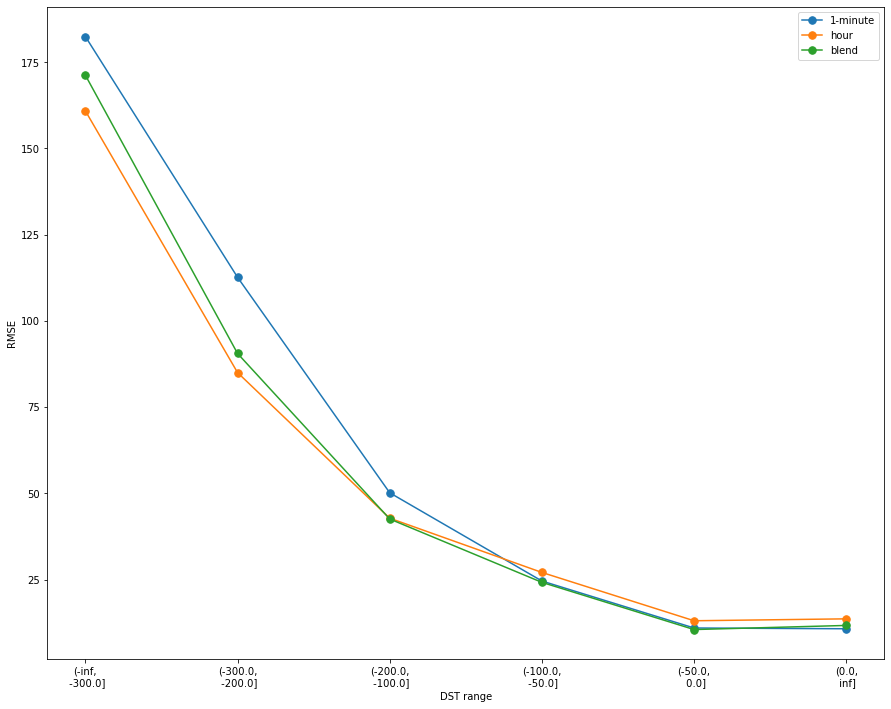

In [9]:
# plot errors in different DST ranges
plt.figure(figsize=(15, 12))
bins = [-np.inf, -300, -200, -100, -50, 0, np.inf]
plot_binned_RMSE(dst_test_1_min.loc[valid_ind, "dst"].values, dst_test_1_min.loc[valid_ind, "prediction_t"].values, bins)
plot_binned_RMSE(dst_test_hourly.loc[valid_ind, "dst"].values, dst_test_hourly.loc[valid_ind, "prediction_t"].values, bins)
plot_binned_RMSE(dst_test_blend.loc[valid_ind, "dst"].values, dst_test_blend.loc[valid_ind, "prediction_t"].values, bins)
plt.legend(["1-minute", "hour", "blend"])

In [10]:
# size of ranges
bin_id = pd.cut(dst_test_1_min.loc[valid_ind, "dst"], bins).to_frame("bin")
bin_id.groupby("bin").size().to_frame("size")

,size
bin,
"(-inf, -300.0]",17
"(-300.0, -200.0]",33
"(-200.0, -100.0]",436
"(-100.0, -50.0]",2516
"(-50.0, 0.0]",43218
"(0.0, inf]",12454


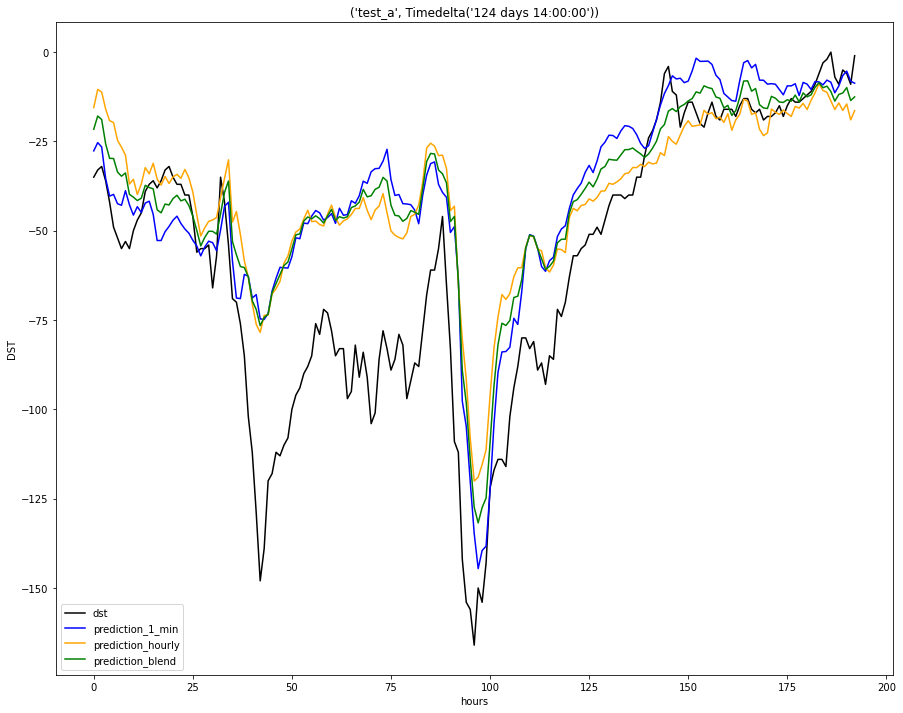

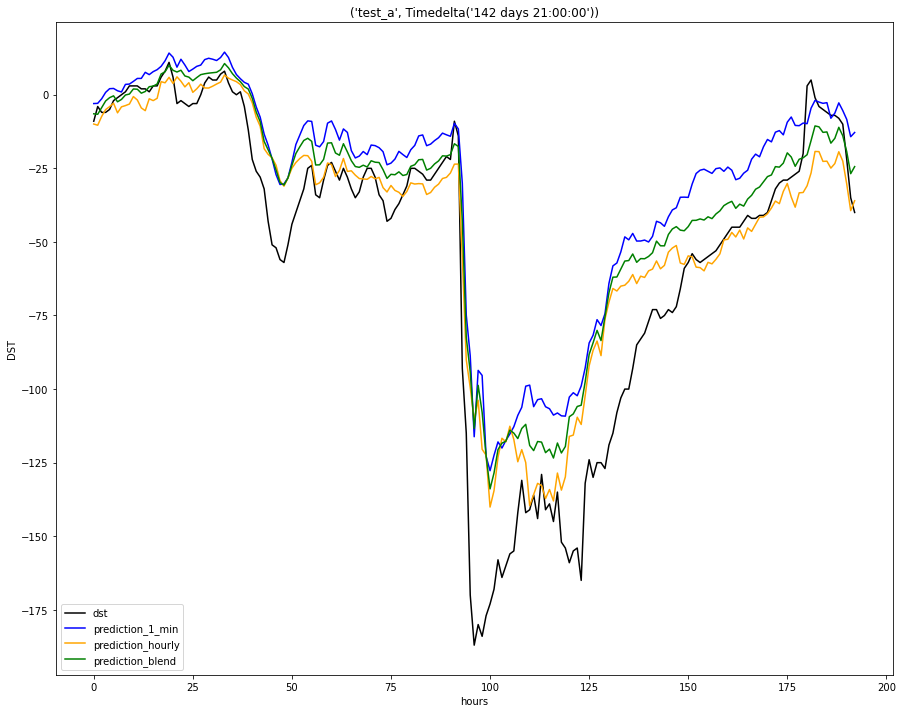

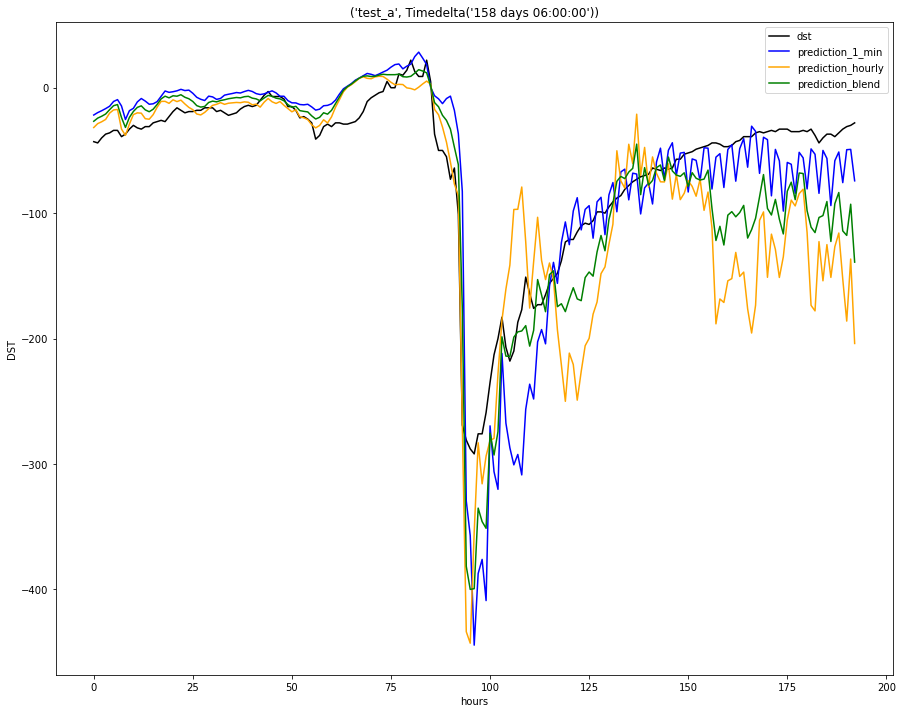

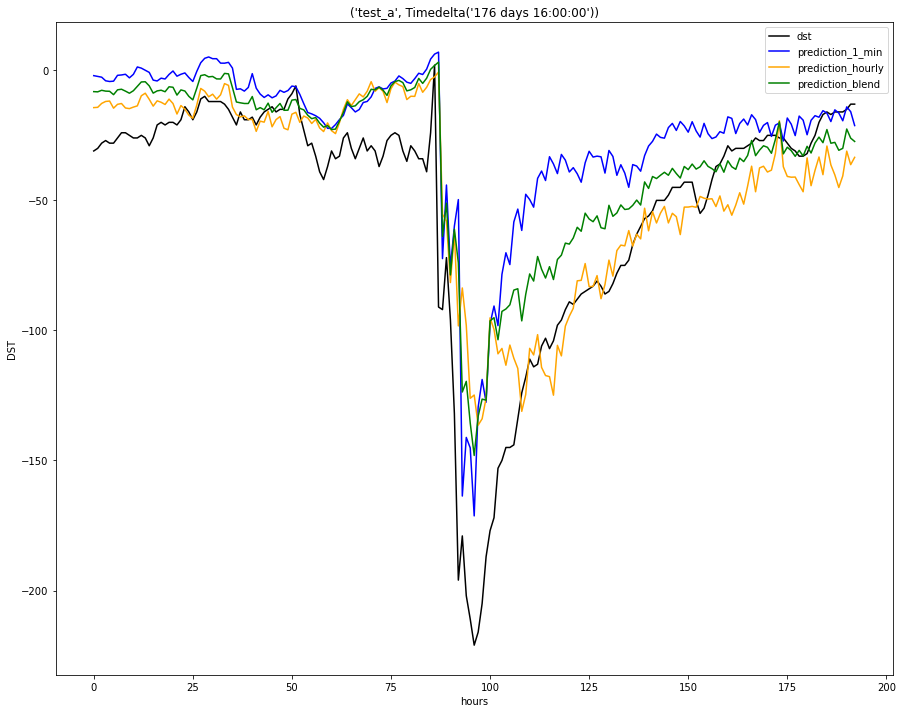

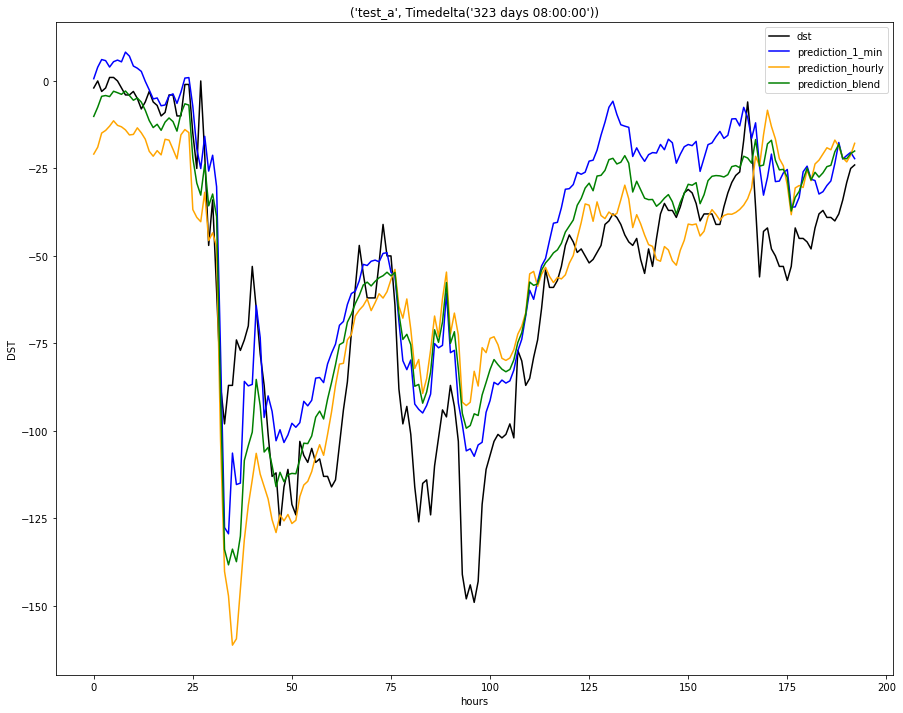

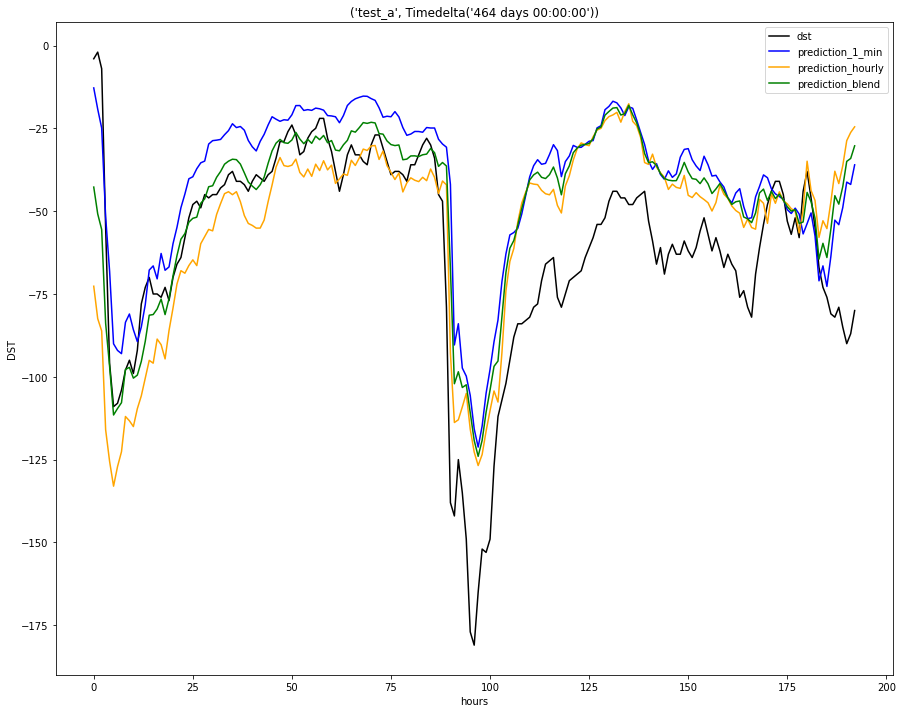

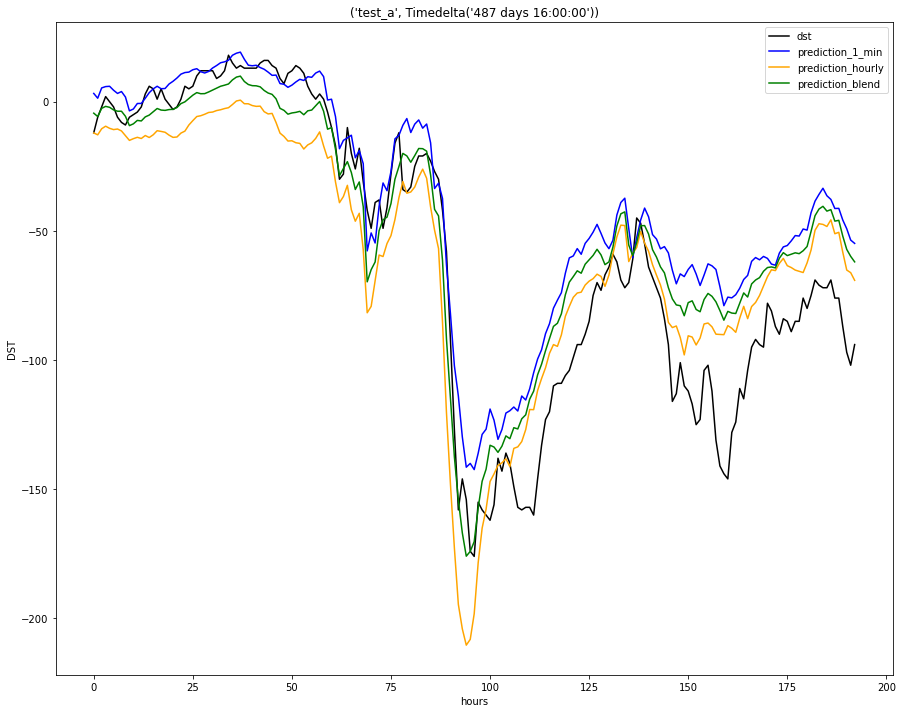

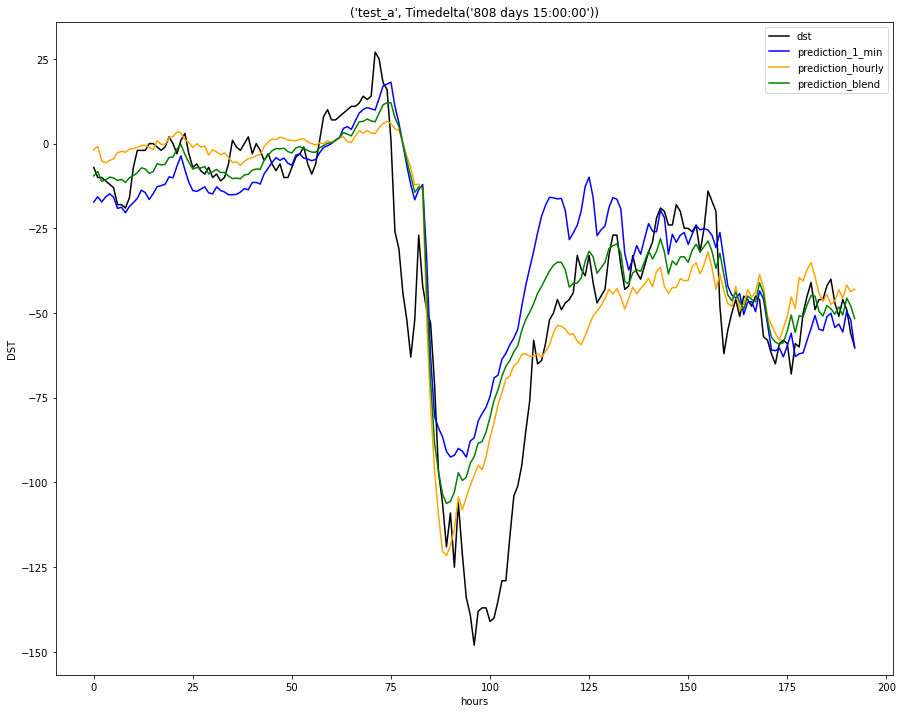

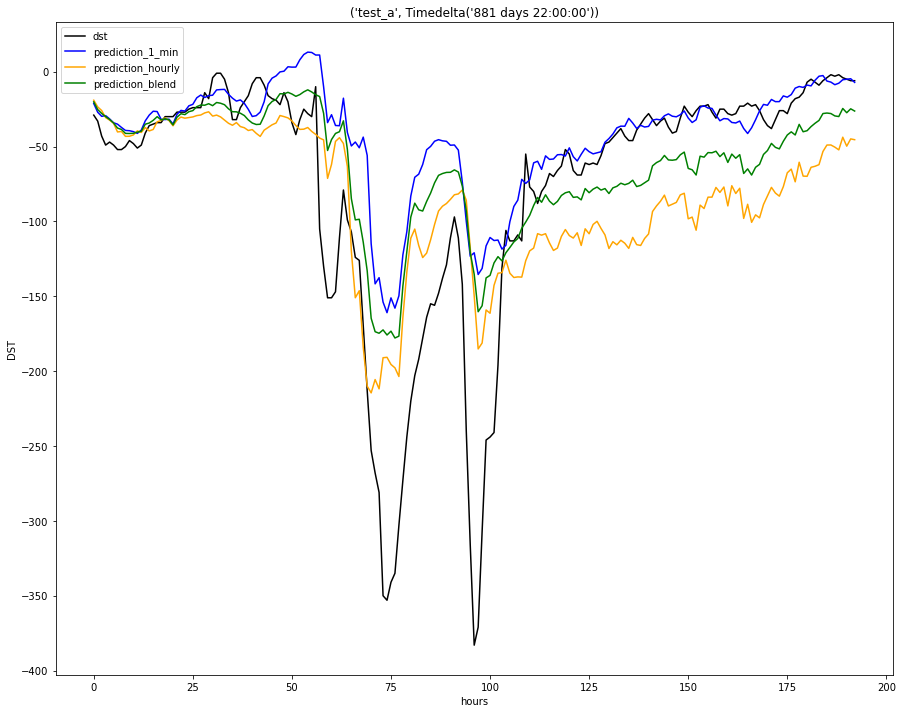

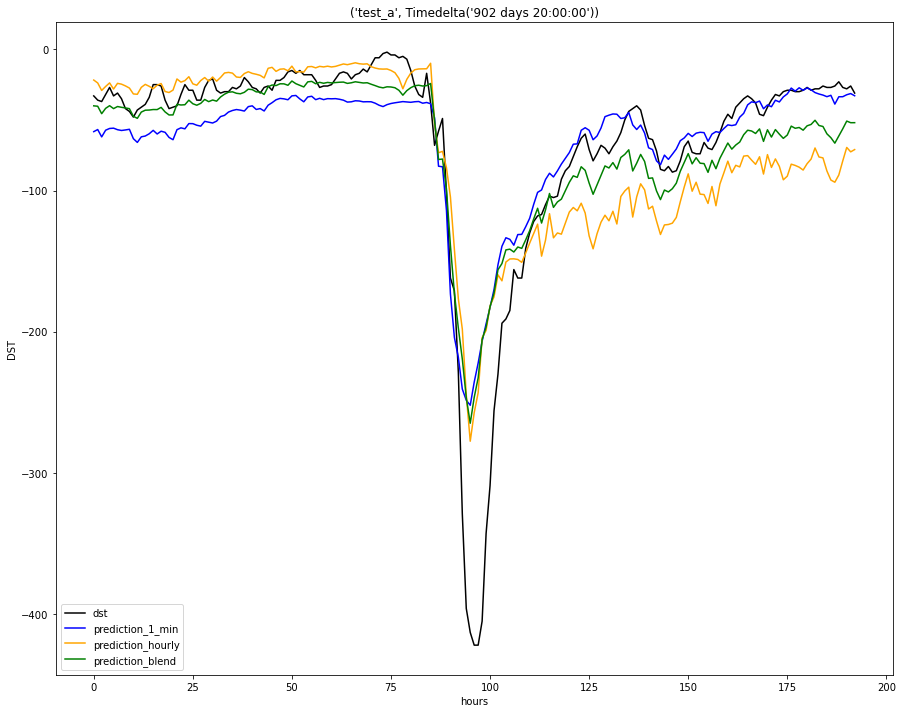

In [11]:
# plot forecast vs actual at storm events
# select events at least 7 days apart
num_events = 10
min_ind_arr = []
min_time_arr = []
labels = []
# dst
dst_test['exclude'] = False
for i in range(num_events):
    min_ind = dst_test.loc[~dst_test['exclude'], 'dst'].idxmin()
    min_time = dst_test.loc[min_ind, ['timedelta', 'period']]
    min_time_arr.append(min_time)
    t, p = min_time['timedelta'], min_time['period']
    min_ind_arr.append(min_ind)
    labels.append(f"{min_time['period'], min_time['timedelta']}")
    dst_test['exclude'] = dst_test['exclude'] | (((dst_test['timedelta'] - t).dt.total_seconds().abs() <= 7 * 24 * 3600) & (dst_test['period'] == p))

# sort by period and timedelta
sort_ind = list(range(num_events))
sort_ind = sorted(sort_ind, key=lambda x: (min_time_arr[x]['period'], min_time_arr[x]['timedelta']))
min_ind_arr = [min_ind_arr[i] for i in sort_ind]
labels = [labels[i] for i in sort_ind]


for i in range(num_events):
    # extract 96 hours before and after max
    ind = min_ind_arr[i]
    # centre on min within 96 * 2 hour window
    new_min = dst_test.loc[ind - 96: ind + 96, 'dst'].idxmin()
    df = dst_test.loc[new_min - 96: new_min + 96].copy()
    df = pd.merge(df, dst_test_1_min[["period", "timedelta", "prediction_t"]], how="left", on=["timedelta", "period"])
    df.rename(columns={"prediction_t": "prediction_1_min"}, inplace=True)
    df = pd.merge(df, dst_test_hourly[["period", "timedelta", "prediction_t"]], how="left", on=["timedelta", "period"])
    df.rename(columns={"prediction_t": "prediction_hourly"}, inplace=True)
    df = pd.merge(df, dst_test_blend[["period", "timedelta", "prediction_t"]], how="left", on=["timedelta", "period"])
    df.rename(columns={"prediction_t": "prediction_blend"}, inplace=True)
    plt.figure(figsize=(15, 12))
    plt.plot(df["dst"].values, c="black")
    plt.plot(df["prediction_1_min"].values, c="blue")
    plt.plot(df["prediction_hourly"].values, c="orange")
    plt.plot(df["prediction_blend"].values, c="green")
    plt.legend(["dst", "prediction_1_min", "prediction_hourly", "prediction_blend"])
    plt.title(labels[i])
    plt.xlabel("hours")
    plt.ylabel("DST")

